In [2]:
import sys
sys.path.insert(0, '../src')
import harmoutil

import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit

from keras.models import Model
from keras.layers import Input, Dense, GRU, concatenate

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.models import load_model

import matplotlib.pyplot as plt

/home/maxime/.local/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Load data
raw_data = harmoutil.load_pickled_data("../data/refined_data.pkl") # lists of (chord label, melody seqs) by sections
print("---Raw data---")
print("Number of sections: {}".format(len(raw_data)))
print("Sample section: {}\n".format(raw_data[0]))
augmented_data = harmoutil.transpose_and_augment_data(raw_data)
print("---Transpose and augment data---")
print("Number of sections after data augmentation: {}".format(len(augmented_data)))
print("Sample section: {}\n".format(augmented_data[0]))
data = [harmoutil.to_sevenths(section) for section in augmented_data]
print("---Truncate chords to sevenths---")
print("Number of sections: {}".format(len(data)))
print("Sample section: {}\n".format(data[0]))
data = [harmoutil.melody_to_octave_range(section) for section in data]
print("---Convert melody to integers---")
print("Number of sections: {}".format(len(data)))
print("Sample section: {}\n".format(data[0]))

---Raw data---
Number of sections: 2408
Sample section: [('Bb6', [[58.0], [58.0]]), ('G7', [[-1.0], [-1.0]]), ('C-7', [[-1.0], [-1.0]]), ('F7', [[-1.0], [-1.0]]), ('Bb', [[-1.0], [-1.0]]), ('G-7', [[50.0], [57.0, 60.0]]), ('C-7', [[58.0, 55.0], [58.0]]), ('F7', [[61.0], [60.0, 58.0]]), ('F-7', [[60.0], [58.0]]), ('Bb7', [[56.0, 60.0], [59.0, 57.0]]), ('Eb7', [[58.0, 54.0], [55.0, 58.0]]), ('Ab7', [[61.0, 56.0], [61.0, 62.0]]), ('D-7', [[58.0, 60.0], [55.0, 58.0]]), ('G7', [[58.0], [-1.0]]), ('C-7', [[-1.0], [-1.0]]), ('F7', [[-1.0], [-1.0]])]

---Transpose and augment data---
Number of sections after data augmentation: 28884
Sample section: [('E6', [[52.0], [52.0]]), ('Db7', [[-1.0], [-1.0]]), ('Gb-7', [[-1.0], [-1.0]]), ('B7', [[-1.0], [-1.0]]), ('E', [[-1.0], [-1.0]]), ('Db-7', [[44.0], [51.0, 54.0]]), ('Gb-7', [[52.0, 49.0], [52.0]]), ('B7', [[55.0], [54.0, 52.0]]), ('B-7', [[54.0], [52.0]]), ('E7', [[50.0, 54.0], [53.0, 51.0]]), ('A7', [[52.0, 48.0], [49.0, 52.0]]), ('D7', [[55.0, 

In [4]:
# Create individual chord and melody element lists 
def get_notes_by_chord(beats):
    return [note for beat in beats for note in beat]

def get_chords_by_section(section):
    return [chord_info[0] for chord_info in section]

def check_if_augmented_major(section):
    section_chords = get_chords_by_section(section)
    for ch in section_chords:
        if "+j7" in ch:
            return True
    return False


# Remove sections that involve augmented major chords (since not enough data to even allow StratifiedShuffleSplit)
data = [section for section in data if not check_if_augmented_major(section)]
print("---Remove sections with augmented major chord---")
print("Number of sections: {}\n".format(len(data)))

chords_by_sections = [get_chords_by_section(section) for section in data]
chords = [chord_info[0] for section in data for chord_info in section]
notes_by_chords = [get_notes_by_chord(chord_info[1]) for section in data for chord_info in section]
notes = [note for chord_notes in notes_by_chords for note in chord_notes]
# print(sum([len(section) for section in chords_by_sections]))
print("Number of sections: {} | Sample section chords: {}".format(len(chords_by_sections), chords_by_sections[0]))
print("Number of chords: {} | Sample chord: {}".format(len(chords), chords[0]))
print("Number of melodies {} | Sample melody: {}".format(len(notes_by_chords), notes_by_chords[0]))
print("Number of melody notes in the data: {} | Sample melody note: {}".format(len(notes), notes[0]))

---Remove sections with augmented major chord---
Number of sections: 28836

Number of sections: 28836 | Sample section chords: ['E6', 'Db7', 'Gb-7', 'B7', 'E', 'Db-7', 'Gb-7', 'B7', 'B-7', 'E7', 'A7', 'D7', 'Ab-7', 'Db7', 'Gb-7', 'B7']
Number of chords: 333480 | Sample chord: E6
Number of melodies 333480 | Sample melody: [4, 4]
Number of melody notes in the data: 2195328 | Sample melody note: 4


In [5]:
# Create categorical data mappings

# Note to integer index
note_to_int = dict([(c, i) for i, c in enumerate(sorted(list(set(notes)))[1:])])
note_to_int[-1] = len(note_to_int)
note_to_int['<pad>'] = len(note_to_int)
print("Melody note to integer mapping:\n {}\n".format(note_to_int))

# Integer to note
int_to_note = dict([(k, v) for v, k in note_to_int.items()])
print("Integer to melody note mapping:\n {}\n".format(int_to_note))

# Chord to integer index
chord_to_int = dict([(c, i) for i, c in enumerate(sorted(list(set(chords))))])
chord_to_int['<bos>'] = len(chord_to_int)
print("Chord label to integer mapping:\n {}\n".format(chord_to_int))


# Integer to chord index
int_to_chord = dict([(k, v) for v, k in chord_to_int.items()])
print("Integer to chord label mapping:\n {}\n".format(int_to_chord))

Melody note to integer mapping:
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, '<pad>': 13, -1: 12}

Integer to melody note mapping:
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: -1, 13: '<pad>'}

Chord label to integer mapping:
 {'A-j7': 6, 'Bb6': 46, 'C-7': 65, 'A+': 1, 'B+': 31, 'Do7': 102, 'Bo': 56, 'Asus': 28, 'Bb': 39, 'Eb-7': 119, 'Gb-7': 164, 'F6': 142, 'D-j7': 81, 'Bbm7b5': 49, 'Fj7': 144, 'Gsus7': 179, 'Bj7': 54, 'Cm7b5': 70, 'Ebo': 125, 'C7': 68, 'Ao7': 27, 'C6': 67, 'Bbj7': 48, 'D7': 83, '<bos>': 181, 'Abj7': 18, 'E6': 112, 'Fsus': 148, 'Eb-j7': 120, 'Eb': 114, 'Ab-7': 14, 'Ab': 9, 'D-': 78, 'Gb7': 167, 'Ab-': 12, 'Co7': 72, 'Db6': 91, 'F+': 136, 'Gb-6': 163, 'D+': 76, 'C+7': 62, 'Db-j7': 90, 'Bb7': 47, 'A+7': 2, 'Gj7': 174, 'Go': 176, 'Asus7': 29, 'B6': 37, 'B-': 33, 'Gb-j7': 165, 'Gbo7': 171, 'A-6': 4, 'G-6': 154, 'Esus7': 134, 'G': 150, 'E+': 106, 'Gm7b5': 175, 'Bbsus7': 53, 'Ebsus': 127, 'A-7': 5, 'D-7':

In [6]:
# Define numerical variables

n_samples = len(chords)
n_notes = len(note_to_int)
n_chords = len(chord_to_int)
max_melody_len = max([len(mel_seq) for mel_seq in notes_by_chords])
chord_context_len = 7

print("Total number of samples: {}".format(n_samples))
print("Number of distinct melody notes: {}".format(n_notes))
print("Number of distinct chord labels: {}".format(n_chords))
print("Maximum melody sequence length: {}".format(max_melody_len))
print("Fixed context chord sequence length: {}".format(7))

Total number of samples: 333480
Number of distinct melody notes: 14
Number of distinct chord labels: 182
Maximum melody sequence length: 135
Fixed context chord sequence length: 7


In [7]:
# Prepare tensor data

def pad_melody(melody, max_len):
    return melody + (max_len-len(melody))*['<pad>']

def build_input_chord_sequences(chord_seq, context_len):
    padded_sequence = context_len*['<bos>'] + chord_seq
    formatted_sequences = [padded_sequence[i:i+context_len+1] for i in range(len(chord_seq))]
    return formatted_sequences

# Melody
input_melody_data = [pad_melody(melody, max_melody_len) for melody in notes_by_chords]
print("Sample input melody sequence: {}\n".format(input_melody_data[5]))


# Chords
formatted_chords_data = []
for section_chords in chords_by_sections:
    formatted_chords_data += build_input_chord_sequences(section_chords, chord_context_len)

input_chords_data = [ch[:-1] for ch in formatted_chords_data]
target_chords_data = [ch[-1] for ch in formatted_chords_data]
print("Sample input chord sequence: {}\n".format(input_chords_data[5]))
print("Sample target chord: {}\n".format(target_chords_data[5]))

print("Input melody: {}, Input chords: {}, Target chords: {}".format(len(input_melody_data), len(input_chords_data), len(target_chords_data)))

Sample input melody sequence: [8, 3, 6, '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>

In [8]:
# Build tensors

X_melody = np.zeros((n_samples, max_melody_len, n_notes), dtype='float32')
X_chords = np.zeros((n_samples, chord_context_len, n_chords), dtype='float32')
Y = np.zeros((n_samples, n_chords), dtype='float32')

for i, (input_mel, input_ch, target_ch) in enumerate(zip(input_melody_data, input_chords_data, target_chords_data)):
    Y[i, chord_to_int[target_ch]] = 1
    for j, chord in enumerate(input_ch):
        X_chords[i, j, chord_to_int[chord]] = 1
        
    for j, note in enumerate(input_mel):
        X_melody[i, j, note_to_int[note]] = 1


In [9]:
# Test melody tensor

def test_samples_axis(melody_tensor):
    count = 0
    sample_axis_sums = melody_tensor.sum(axis=2)
    for entry in sample_axis_sums.ravel():
        count += 1
        if not (entry == 1):
            return (False, count)
    return (True, count, np.sum(sample_axis_sums), np.sum(melody_tensor), np.sum(melody_tensor, dtype=np.int32))

# Test n_samples axis i.e. axis 1. If there are any "holes" (non-1) entry, it's a problem
print("{} = (n_samples, max_melody_len, n_notes)".format(X_melody.shape))
print(test_samples_axis(X_melody))

(333480, 135, 14) = (n_samples, max_melody_len, n_notes)
(True, 45019800, 45019800.0, 44982130.0, 45019800)


In [10]:
# Split dataset into 80%-10%-10% train-valid-test

seed = 0

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

for train_index, aux_index in sss.split(X_chords, Y):
    X_melody_train, X_melody_aux = X_melody[train_index], X_melody[aux_index]
    X_chords_train, X_chords_aux = X_chords[train_index], X_chords[aux_index]
    Y_train, Y_aux = Y[train_index], Y[aux_index]
    
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)

for valid_index, test_index in sss.split(X_chords_aux, Y_aux):
    X_melody_valid, X_melody_test = X_melody[valid_index], X_melody[test_index]
    X_chords_valid, X_chords_test = X_chords[valid_index], X_chords[test_index]
    Y_valid, Y_test = Y[valid_index], Y[test_index]

Instructions for updating:
keep_dims is deprecated, use keepdims instead
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 135, 14)       0                                            
____________________________________________________________________________________________________
gru_7 (GRU)                      (None, 135, 128)      54912       input_5[0][0]                    
____________________________________________________________________________________________________
input_6 (InputLayer)             (None, 7, 182)        0                                            
____________________________________________________________________________________________________
gru_8 (GRU)                      (None, 128)           98688       gru_7[0][0]                      
__________________

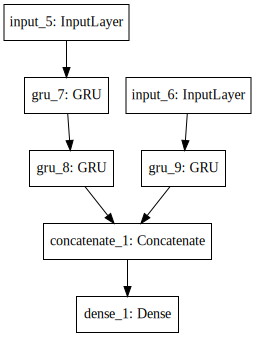

In [13]:
# Define neural net architecture

latent_dim = 128

melody_input = Input(shape=(max_melody_len, n_notes))
melody_gru1 = GRU(latent_dim, return_sequences=True)(melody_input)
melody_gru2 = GRU(latent_dim)(melody_gru1)

chords_input = Input(shape=(chord_context_len, n_chords))
chords_gru = GRU(latent_dim)(chords_input)

concat = concatenate([melody_gru2, chords_gru])

chord_dense = Dense(n_chords, activation='softmax')(concat)

model = Model([melody_input, chords_input], chord_dense)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())
SVG(model_to_dot(model).create(prog='dot', format='svg'))


In [14]:
# Introduce Early-Stopping and Save-Best-Performance callbacks
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
filepath = "../models/label-Mel2-Cho1-FC1_150ep.h5"
bp = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [15]:
# Train model
batch_size = 256
epochs = 150

history = model.fit([X_melody_train, X_chords_train], Y_train, epochs=epochs, validation_data=([X_melody_valid, X_chords_valid], Y_valid,), batch_size=batch_size, callbacks=[bp])

Train on 266784 samples, validate on 33348 samples
Epoch 1/150
266784/266784 [==============================] - 909s - loss: 2.9864 - acc: 0.3356 - val_loss: 2.5387 - val_acc: 0.4252
Epoch 2/150
266784/266784 [==============================] - 910s - loss: 2.4298 - acc: 0.4341 - val_loss: 2.3265 - val_acc: 0.4599
Epoch 3/150
266784/266784 [==============================] - 911s - loss: 2.2454 - acc: 0.4678 - val_loss: 2.2048 - val_acc: 0.4911
Epoch 4/150
266784/266784 [==============================] - 912s - loss: 2.0366 - acc: 0.5095 - val_loss: 1.9332 - val_acc: 0.5461
Epoch 5/150
266784/266784 [==============================] - 913s - loss: 1.8141 - acc: 0.5548 - val_loss: 1.8029 - val_acc: 0.5720
Epoch 6/150
266784/266784 [==============================] - 913s - loss: 1.6904 - acc: 0.5822 - val_loss: 1.7253 - val_acc: 0.5907
Epoch 7/150
266784/266784 [==============================] - 912s - loss: 1.5958 - acc: 0.6041 - val_loss: 1.6700 - val_acc: 0.6027
Epoch 8/150
266784/266784

266784/266784 [==============================] - 914s - loss: 0.8471 - acc: 0.7823 - val_loss: 1.3238 - val_acc: 0.7006
Epoch 26/150
266784/266784 [==============================] - 912s - loss: 0.8272 - acc: 0.7865 - val_loss: 1.3185 - val_acc: 0.7032
Epoch 27/150
266784/266784 [==============================] - 911s - loss: 0.8164 - acc: 0.7891 - val_loss: 1.3101 - val_acc: 0.7081
Epoch 28/150
266784/266784 [==============================] - 910s - loss: 0.8046 - acc: 0.7913 - val_loss: 1.3096 - val_acc: 0.7109
Epoch 29/150
266784/266784 [==============================] - 910s - loss: 0.7956 - acc: 0.7931 - val_loss: 1.3016 - val_acc: 0.7122
Epoch 30/150
266784/266784 [==============================] - 910s - loss: 0.7604 - acc: 0.8026 - val_loss: 1.2974 - val_acc: 0.7146
Epoch 31/150
266784/266784 [==============================] - 912s - loss: 0.7429 - acc: 0.8070 - val_loss: 1.2924 - val_acc: 0.7174
Epoch 32/150
266784/266784 [==============================] - 914s - loss: 0.7277 

266784/266784 [==============================] - 913s - loss: 0.5398 - acc: 0.8543 - val_loss: 1.2936 - val_acc: 0.7426
Epoch 54/150
266784/266784 [==============================] - 914s - loss: 0.5251 - acc: 0.8584 - val_loss: 1.2954 - val_acc: 0.7446
Epoch 55/150
266784/266784 [==============================] - 912s - loss: 0.5385 - acc: 0.8531 - val_loss: 1.3344 - val_acc: 0.7355
Epoch 56/150
266784/266784 [==============================] - 911s - loss: 0.5398 - acc: 0.8526 - val_loss: 1.3104 - val_acc: 0.7435
Epoch 57/150
266784/266784 [==============================] - 915s - loss: 0.5149 - acc: 0.8612 - val_loss: 1.3053 - val_acc: 0.7463
Epoch 58/150
266784/266784 [==============================] - 918s - loss: 0.5258 - acc: 0.8571 - val_loss: 1.2979 - val_acc: 0.7472
Epoch 59/150
266784/266784 [==============================] - 917s - loss: 0.5033 - acc: 0.8636 - val_loss: 1.2997 - val_acc: 0.7475
Epoch 60/150
266784/266784 [==============================] - 917s - loss: 0.5603 

266784/266784 [==============================] - 915s - loss: 0.4371 - acc: 0.8783 - val_loss: 1.3372 - val_acc: 0.7559
Epoch 83/150
266784/266784 [==============================] - 915s - loss: 0.4220 - acc: 0.8832 - val_loss: 1.3328 - val_acc: 0.7573
Epoch 84/150
266784/266784 [==============================] - 915s - loss: 0.4286 - acc: 0.8809 - val_loss: 1.3447 - val_acc: 0.7565
Epoch 85/150
266784/266784 [==============================] - 915s - loss: 0.4243 - acc: 0.8816 - val_loss: 1.3565 - val_acc: 0.7522
Epoch 86/150
266784/266784 [==============================] - 920s - loss: 0.4324 - acc: 0.8791 - val_loss: 1.3539 - val_acc: 0.7555
Epoch 87/150
266784/266784 [==============================] - 921s - loss: 0.4559 - acc: 0.8715 - val_loss: 1.3563 - val_acc: 0.7523
Epoch 88/150
266784/266784 [==============================] - 920s - loss: 0.4189 - acc: 0.8826 - val_loss: 1.3413 - val_acc: 0.7589
Epoch 89/150
266784/266784 [==============================] - 919s - loss: 0.4200 

266784/266784 [==============================] - 917s - loss: 0.3936 - acc: 0.8880 - val_loss: 1.4210 - val_acc: 0.7486
Epoch 113/150
266784/266784 [==============================] - 920s - loss: 0.3864 - acc: 0.8900 - val_loss: 1.4008 - val_acc: 0.7541
Epoch 114/150
266784/266784 [==============================] - 914s - loss: 0.3727 - acc: 0.8945 - val_loss: 1.3920 - val_acc: 0.7605
Epoch 115/150
266784/266784 [==============================] - 914s - loss: 0.4397 - acc: 0.8741 - val_loss: 1.4084 - val_acc: 0.7530
Epoch 116/150
266784/266784 [==============================] - 913s - loss: 0.4320 - acc: 0.8757 - val_loss: 1.4319 - val_acc: 0.7476
Epoch 117/150
266784/266784 [==============================] - 913s - loss: 0.3986 - acc: 0.8863 - val_loss: 1.4535 - val_acc: 0.7434
Epoch 118/150
266784/266784 [==============================] - 917s - loss: 0.3995 - acc: 0.8857 - val_loss: 1.3798 - val_acc: 0.7624
Epoch 119/150
266784/266784 [==============================] - 918s - loss: 

266784/266784 [==============================] - 915s - loss: 0.3848 - acc: 0.8883 - val_loss: 1.4058 - val_acc: 0.7634
Epoch 144/150
266784/266784 [==============================] - 914s - loss: 0.3535 - acc: 0.8982 - val_loss: 1.4096 - val_acc: 0.7624
Epoch 145/150
266784/266784 [==============================] - 914s - loss: 0.3583 - acc: 0.8971 - val_loss: 1.4575 - val_acc: 0.7525
Epoch 146/150
266784/266784 [==============================] - 914s - loss: 0.4767 - acc: 0.8615 - val_loss: 1.4152 - val_acc: 0.7587
Epoch 147/150
266784/266784 [==============================] - 914s - loss: 0.3648 - acc: 0.8950 - val_loss: 1.4086 - val_acc: 0.7630
Epoch 148/150
266784/266784 [==============================] - 914s - loss: 0.3708 - acc: 0.8933 - val_loss: 1.4006 - val_acc: 0.7643
Epoch 149/150
266784/266784 [==============================] - 914s - loss: 0.4174 - acc: 0.8787 - val_loss: 1.4315 - val_acc: 0.7558
Epoch 150/150
266784/266784 [==============================] - 917s - loss: 

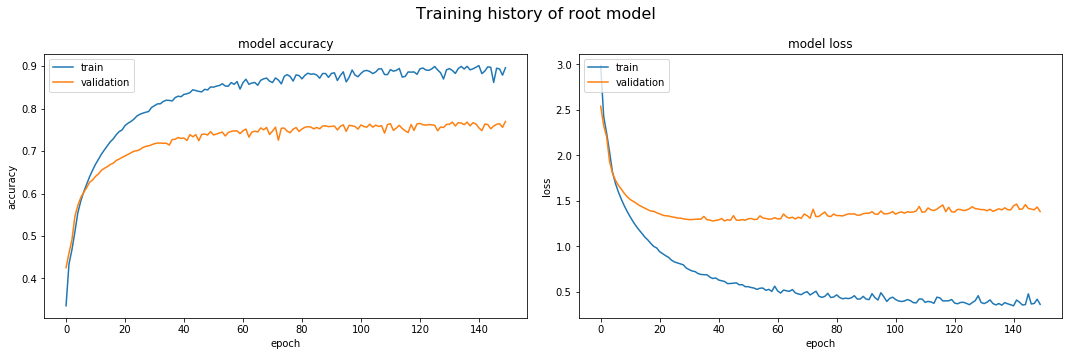

In [16]:
# Visualize model learning
plt.clf()

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()
plt.suptitle("Training history of root model", fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

In [17]:
# Load best performance model
model = load_model("../models/label-Mel2-Cho1-FC1_150ep.h5")

In [18]:
# Evaluate predictions in terms of labels

# Predict chords from each test sample melody
Y_pred = model.predict([X_melody_test, X_chords_test])

# Compute accuracy and kappa score
print("Categorical accuracy of combined chord label prediction: {0:.4f}".format(harmoutil.compute_accuracy_score(Y_test, Y_pred)))
print("Kappa score of combined chord label prediction: {0:.4f}".format(harmoutil.compute_kappa_score(Y_test, Y_pred)))

Categorical accuracy of combined chord label prediction: 0.7703
Kappa score of combined chord label prediction: 0.7646


In [19]:
# Evaluate predictions in terms of pitches

def label_to_pitch_tensors(predictions):
    predicted_chords = [int_to_chord[np.argmax(ch)] for ch in predictions]
    pitch_chords = [harmoutil.chord_to_notes(label) for label in predicted_chords]
    
    Y_pitches = np.zeros((predictions.shape[0], 12), dtype='float32')
    for i, chord_pitches in enumerate(pitch_chords):
        for j, pitch_presence in enumerate(chord_pitches):
            Y_pitches[i, j] = pitch_presence

    return Y_pitches
    
    
Y_pred_pitch = label_to_pitch_tensors(Y_pred)
Y_test_pitch = label_to_pitch_tensors(Y_test)

print("Categorical accuracy of combined chord pitch prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_accuracy_score(Y_test_pitch, Y_pred_pitch)))
print("Kappa score of combined chord pitch prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_kappa_score(Y_test_pitch, Y_pred_pitch)))

Categorical accuracy of combined chord pitch prediction: 0.9059
TP: 111378 TN: 251126 FP: 18924 FN: 18748
Kappa score of combined chord pitch prediction: 0.7856


In [61]:
# print("F-score: {0:.4f}".format(harmoutil.compute_binary_fscore(Y_test_pitch, Y_pred_pitch)))